<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Vgg16model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
%cd drive

/content/drive


In [26]:
%cd MyDrive

/content/drive/MyDrive


In [27]:
%cd medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [1]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

Cloning into 'medical-image-analysis'...
remote: Enumerating objects: 3805, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 3805 (delta 21), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3805/3805), 337.21 MiB | 42.85 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Checking out files: 100% (3890/3890), done.


In [2]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import itertools
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from glob import glob

In [3]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [4]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 161.14it/s]


In [5]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [6]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [7]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [8]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [9]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [10]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [11]:
#load in pretrained model
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  print(layer.name)
  layer.trainable = False
print(len(vgg.layers))

58900480/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [12]:
#adding output layer
top_model = vgg.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)

In [13]:
#create a model object
model1 = Model(inputs=vgg.input, outputs=output_layer)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
#Feature extraction
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
val_datagen.fit(X_val)


In [15]:
batch_size = 64
epochs = 10
history = model1.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))


Epoch 1/10
33/33 [==============================] - 91s 1s/step - loss: 11.6325 - accuracy: 0.4749 - val_loss: 2.1485 - val_accuracy: 0.5625
Epoch 2/10
33/33 [==============================] - 25s 771ms/step - loss: 1.9917 - accuracy: 0.5715 - val_loss: 1.1852 - val_accuracy: 0.5513
Epoch 3/10
33/33 [==============================] - 25s 772ms/step - loss: 1.1276 - accuracy: 0.6159 - val_loss: 0.9004 - val_accuracy: 0.6027
Epoch 4/10
33/33 [==============================] - 26s 771ms/step - loss: 0.9297 - accuracy: 0.6189 - val_loss: 0.9206 - val_accuracy: 0.5737
Epoch 5/10
33/33 [==============================] - 26s 785ms/step - loss: 0.8404 - accuracy: 0.6461 - val_loss: 0.7974 - val_accuracy: 0.6317
Epoch 6/10
33/33 [==============================] - 26s 779ms/step - loss: 0.7173 - accuracy: 0.6775 - val_loss: 0.9175 - val_accuracy: 0.5826
Epoch 7/10
33/33 [==============================] - 25s 772ms/step - loss: 0.7312 - accuracy: 0.6703 - val_loss: 0.8266 - val_accuracy: 0.6161
E

In [16]:
#Fine-Tuning 
for layer in model1.layers[14:]:
    layer.trainable = True

In [17]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [18]:
batch_size = 64
epochs = 30
history = model1.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
33/33 [==============================] - 30s 809ms/step - loss: 0.8921 - acc: 0.6206 - val_loss: 0.8054 - val_acc: 0.5938
Epoch 2/30
33/33 [==============================] - 26s 792ms/step - loss: 0.7598 - acc: 0.6448 - val_loss: 0.7599 - val_acc: 0.6562
Epoch 3/30
33/33 [==============================] - 26s 791ms/step - loss: 0.7037 - acc: 0.6726 - val_loss: 0.7735 - val_acc: 0.6629
Epoch 4/30
33/33 [==============================] - 26s 791ms/step - loss: 0.6406 - acc: 0.7087 - val_loss: 0.7174 - val_acc: 0.6741
Epoch 5/30
33/33 [==============================] - 27s 800ms/step - loss: 0.5802 - acc: 0.7362 - val_loss: 0.7710 - val_acc: 0.6696
Epoch 6/30
33/33 [==============================] - 26s 791ms/step - loss: 0.5019 - acc: 0.7693 - val_loss: 0.7416 - val_acc: 0.7009
Epoch 7/30
33/33 [==============================] - 26s 791ms/step - loss: 0.5108 - acc: 0.7773 - val_loss: 0.6485 - val_acc: 0.7121
Epoch 8/30
33/33 [==============================] - 26s 795ms/step - 

In [19]:
loss_val, acc_val = model1.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

30/30 [==============================] - 5s 155ms/step - loss: 0.9494 - acc: 0.8206
Validation: accuracy = 0.820623  ;  loss_v = 0.949396


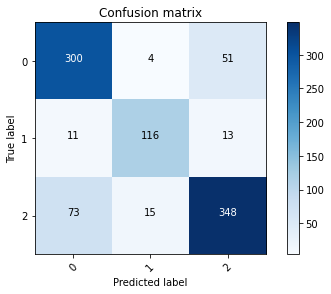

In [20]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model1.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

TESTING1


In [21]:
loss_test, acc_test = model1.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 5s 206ms/step - loss: 1.0122 - acc: 0.8018
Test: accuracy = 0.801802  ;  loss = 1.012165


Text(0.5, 1.0, 'Training and validation loss')

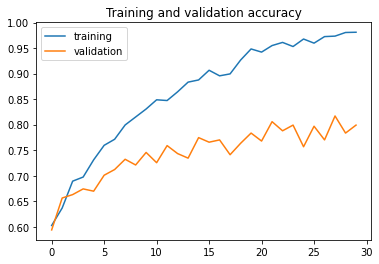

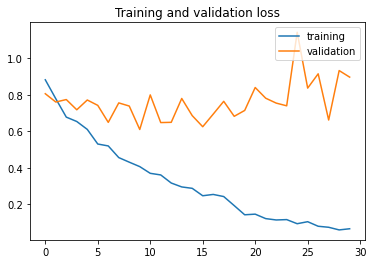

In [22]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [28]:
model1.save("VGG16model1.h5")